In [1]:
import matplotlib.pyplot as plt

In [2]:
from __future__ import annotations
from abc import ABC, abstractmethod
from enum import Enum

class RecombinationType(Enum):
    ONE_POINT=1
    TWO_POINT=2
    UNIFORM=3
    
class Genotype(ABC):
    '''Abstract class respresenting possible solution'''
    def __init__(self, solution=None):
        self.solution = solution if solution else self.random_solution()
        self.score = 0
        self.evaluate()
    
    def evaluate(self)-> float:
        self.score = self._evaluate()
        return self.score
    
    def mutate(self,mutation_prob:float) -> float:
        assert mutation_prob > 0 and mutation_prob <=1
        self._mutate(mutation_prob)
        self.evaluate()
    
    @abstractmethod
    def _evaluate(self) -> float:
        pass
    
    @abstractmethod
    def _mutate(self, mutation_prob:float) -> None:
        pass
    
    @abstractmethod
    def random_solution(self,*args):
        pass
    
    @abstractmethod
    def recombine(self, partner, recombination_type: RecombinationType=RecombinationType.ONE_POINT) -> Genotype:
        pass

In [3]:
import random

L=50 #global variable

class LABSGenotype(Genotype):
    '''Problem-specific genotype implementation.'''
    
    def calculate_autocorrelation(self, k_value: int) -> int:
        return sum(self.solution[idx]*self.solution[idx+k_value] for idx in range(len(self.solution) - k_value ))

    def calculate_total_energy(self) -> int:
        return sum(self.calculate_autocorrelation(k_value)**2 for k_value in range(1, len(self.solution)))

    def calculate_merit_factor(self) -> float:
        return (len(self.solution)**2)/(2*self.calculate_total_energy())
    
    def _evaluate(self) -> float:
        return self.calculate_merit_factor()
    
    def random_solution(self):
        return [random.choice([-1,1]) for i in range(L)]
    
    def _mutate(self, mutation_prob: float) -> None:
        '''Mutation by flipping some bits.'''
        
        how_many_bits = int(len(self.solution)*mutation_prob)
        to_flip = random.sample(range(len(self.solution)),k=how_many_bits)
        
        for i in to_flip:
            self.solution[i] *= -1
            
    def recombine(self, partner: LABSGenotype, recombination_type: RecombinationType=RecombinationType.ONE_POINT) -> Genotype:
        #TODO: recombination can be also asexual i.e. by just mutating single agent
        new_genotype = LABSGenotype()
        
        if recombination_type == RecombinationType.ONE_POINT: 
            #single point recombination e.g. 'aaaaaaabbbbbbbb'
            
            division_point = random.choice(range(len(self.solution)-2))
            new_genotype.solution = self.solution[:division_point+1] + partner.solution[division_point+1:]
            
        elif recombination_type == RecombinationType.TWO_POINT:
            #double point recombination e.g. 'aaaabbbbbbbaaa'
            
            division_points = sorted(random.sample(range(len(self.solution)-2), k=2))
            new_genotype.solution = self.solution[:division_points[0]+1] + partner.solution[division_points[0]+1:division_points[1]+1] + self.solution[division_points[1]+1:]
            
        else:
            #uniform recombination e.g. 'abababababab'
            for i in range(len(new_genotype.solution)):
                new_genotype.solution[i] = self.solution[i] if i%2 else partner.solution[i]
        
        return new_genotype
            
        
    def __str__(self) -> str:
        return f"<Genotype: {''.join(['1' if x==1 else '0' for x in self.solution])}, mf={self.score}>"
    

genotype_class = LABSGenotype

g1 = genotype_class()
g2 = genotype_class()
recombined = g1.recombine(g2,recombination_type=RecombinationType.TWO_POINT)
print(f"Recombined:\n{g1}\n{g2}\n{recombined}")

recombined.mutate(0.26)
print(f"Mutated: \n{recombined}")

Recombined:
<Genotype: 10001000010101001001010111001001100011001011101000, mf=1.1563367252543941>
<Genotype: 11100011011001101110011001100101000111000111001111, mf=0.862663906142167>
<Genotype: 10001011011001101110011001100101000111001011101000, mf=1.5006002400960383>
Mutated: 
<Genotype: 10001011010101001110001001100111110101111111001010, mf=1.1825922421948911>


In [4]:
class Agent:
    def __init__(self,initial_energy:int, genotype: Genotype=None):
        self.genotype = genotype
        self.energy = initial_energy
    
    def get_score(self)->float:
        return self.genotype.score
    
    def mutate(self, mutation_prob:float)->None:
        self.genotype.mutate(mutation_prob)
        
    def reproduce(self, partner: Agent, recombination_type: RecombinationType=RecombinationType.ONE_POINT)->Agent:
        new_genotype = self.genotype.recombine(partner.genotype,recombination_type)
        return Agent(0,new_genotype)
        
    def __str__(self) -> str:
        return f"<Agent: energy={self.energy}, genotype={self.genotype}>"

In [5]:
import time

class Simulation:
    def __init__(self, 
                 number_of_agents: int = 50, 
                 initial_energy: int = 6,
                 mutation_prob: float = 0.1,
                 reproduction_threshold: int = 6,
                 reproduction_energy_transfer:int = 2,
                 fight_energy_transfer: int =2):
        
        self.agents = [Agent(initial_energy=initial_energy,
                             genotype=genotype_class()) for i in range(number_of_agents)]
        self.mutation_prob = mutation_prob
        self.reproduction_threshold = reproduction_threshold
        self.reproduction_energy_transfer = reproduction_energy_transfer
        self.fight_energy_transfer = fight_energy_transfer
        
    def transfer_energy(self, from_agent:Agent, to_agent:Agent, amount: int) -> None:
     
        to_transfer = from_agent.energy if from_agent.energy < amount else amount
            
        from_agent.energy -= to_transfer
        to_agent.energy += to_transfer
        
        if self.is_dead(from_agent):
            self.agents.remove(from_agent)
        
        if self.is_dead(to_agent):
            self.agents.remove(to_agent)
    
    def reproduce(self, first_partner: Agent, second_partner: Agent)->None:

        new_agent = first_partner.reproduce(second_partner)
        new_agent.mutate(self.mutation_prob)
        self.agents.append(new_agent)
        
        self.transfer_energy(first_partner,new_agent,self.reproduction_energy_transfer)
        self.transfer_energy(second_partner,new_agent,self.reproduction_energy_transfer)
        
        
    def fight(self, first_fighter: Agent, second_fighter: Agent) -> None:
        #conditional mode - winner is the agent with higher score
        if first_fighter.get_score() > second_fighter.get_score():
            self.transfer_energy(second_fighter,first_fighter,self.fight_energy_transfer)
        elif second_fighter.get_score() > first_fighter.get_score():
            self.transfer_energy(first_fighter,second_fighter,self.fight_energy_transfer)
        else:
            #both solutions are equally good
            r = random.choice([0,1])
            if r:
                self.transfer_energy(second_fighter,first_fighter,self.fight_energy_transfer)
            else:
                self.transfer_energy(first_fighter,second_fighter,self.fight_energy_transfer)
                
        #else both solutions are equally good
    
        #probabilistic mode - agent with higher score has higher probability of winning
#         winner = random.choices([0,1],weights=[first_fighter.get_score()**4,second_fighter.get_score()**4],k=1)
        
#         if winner:
#             self.transfer_energy(first_fighter,second_fighter,self.fight_energy_transfer)
#         else:
#             self.transfer_energy(second_fighter,first_fighter,self.fight_energy_transfer)
        
    
    def is_dead(self, agent: Agent) -> bool:
        return agent.energy == 0
    
    def sum_energy(self)->int:
        return sum([agent.energy for agent in self.agents])
    
    def find_best(self)->Agent:
        best = self.agents[0]
        
        for agent in self.agents:
            if agent.get_score() > best.get_score():
                best = agent
                
        return best
            
    
    def step(self):
        
        random.shuffle(self.agents)
                
        fight_pool = self.agents[:int(len(self.agents)*random.uniform(0.2,0.6))]
        #fighting agents
        division_point_fight = len(fight_pool) // 2
        for agent_a, agent_b in zip(fight_pool[:division_point_fight], fight_pool[division_point_fight:]):
            self.fight(agent_a,agent_b)
            
        
        reproduction_pool = list(filter(lambda agent: agent.energy >= self.reproduction_threshold and random.random()>0.5,self.agents ))
        #reproducing agents
        division_point_repr = len(reproduction_pool) // 2
        for agent_a, agent_b in zip(reproduction_pool[:division_point_repr], reproduction_pool[division_point_repr:]):
            self.reproduce(agent_a,agent_b)
            
        return len(reproduction_pool), len(fight_pool)
        
    def simulate(self, simulation_time:float=60.0, log_interval:float=1.0)->None:
        steps = 0
        start = time.time()
        last_log_time = 0
        
        best_scores = []
        pools_length = []
        average_energy = []
        average_mf = []
        number_of_agents = []
        timestamps = []
        
        best_agent = None
        
        while time.time() - start <= simulation_time:
            r_len,f_len = self.step()

            if time.time() - last_log_time > log_interval:
                best_agent = self.find_best()
                best_scores.append(best_agent.get_score())
                pools_length.append([r_len,f_len])
                average_energy.append(sum([agent.energy for agent in self.agents])/len(self.agents))
                average_mf.append(sum([agent.get_score() for agent in self.agents])/len(self.agents))
                number_of_agents.append(len(self.agents))
                print(f"Step {steps+1} - best solution: {best_agent}")
                timestamps.append(time.time() - start)
                last_log_time = time.time()
                
            steps+=1
                
        return best_agent, best_scores, pools_length, average_energy, average_mf, number_of_agents, timestamps


In [10]:
L=20 #size of the problem

sim = Simulation(50,5,mutation_prob=0.1,reproduction_threshold=5,reproduction_energy_transfer=2,fight_energy_transfer=2)
best_agent, best_scores, pools_length, average_energy, average_mf, number_of_agents, timestamps = sim.simulate(60,1)

Step 1 - best solution: <Agent: energy=5, genotype=<Genotype: 11111001110101101101, mf=2.857142857142857>>
Step 2095 - best solution: <Agent: energy=4, genotype=<Genotype: 00000101101011100110, mf=4.761904761904762>>
Step 4253 - best solution: <Agent: energy=6, genotype=<Genotype: 00000101001011001100, mf=5.882352941176471>>
Step 6348 - best solution: <Agent: energy=4, genotype=<Genotype: 00000101001011001100, mf=5.882352941176471>>
Step 8515 - best solution: <Agent: energy=4, genotype=<Genotype: 00000101001011001100, mf=5.882352941176471>>
Step 10534 - best solution: <Agent: energy=8, genotype=<Genotype: 00000101001011001100, mf=5.882352941176471>>
Step 12716 - best solution: <Agent: energy=8, genotype=<Genotype: 00000101001011001100, mf=5.882352941176471>>
Step 14871 - best solution: <Agent: energy=6, genotype=<Genotype: 00000101001011001100, mf=5.882352941176471>>
Step 17097 - best solution: <Agent: energy=10, genotype=<Genotype: 00000101001011001100, mf=5.882352941176471>>
Step 193

In [11]:
print(f"Best solution: {best_agent}")

Best solution: <Agent: energy=0, genotype=<Genotype: 01010000100001101100, mf=7.6923076923076925>>


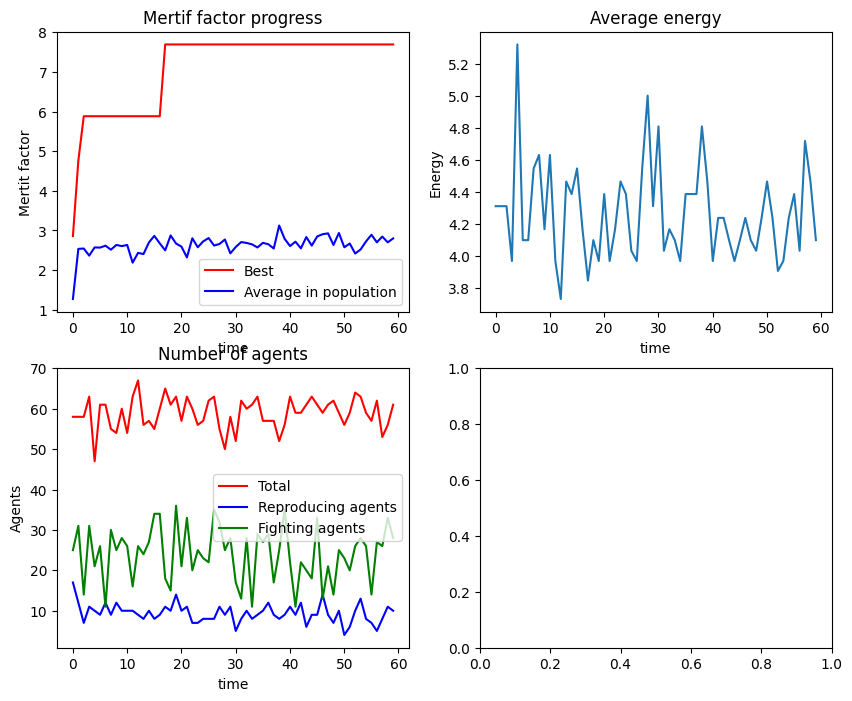

In [12]:
import matplotlib.pyplot as plt
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(10,8))

ax1.plot(timestamps, best_scores,'r',timestamps,average_mf,'b-')
ax1.set_title('Mertif factor progress')
ax1.set_ylabel('Mertit factor')
ax1.set_xlabel('time')
ax1.legend(['Best','Average in population'])

ax2.plot(timestamps,average_energy)
ax2.set_title("Average energy")
ax2.set_ylabel("Energy")
ax2.set_xlabel("time")

ax3.plot(timestamps,number_of_agents,'r',timestamps,[row[0] for row in pools_length],'b',timestamps,[row[1] for row in pools_length],'g')
ax3.set_ylabel('Agents')
ax3.set_xlabel('time')
ax3.set_title('Number of agents')
ax3.legend(['Total','Reproducing agents','Fighting agents'])

plt.show()

In [435]:
import pandas as pd

def multirun_simulation(sim_params,sim_time=60.0,log_interval=1.0,number_of_runs=10):
    aggregated = {
        'best_agent': [],
        'best_scores': [],
        'pools_length': [],
        'average_energy': [],
        'average_mf': [],
        'number_of_agents': [],
        'timestamps': []
    }
    
    for i in range(number_of_runs):
        print(f"***** Simulation run number {i+1}/{number_of_runs} *****")
        sim = Simulation(**sim_params)
        
        best_agent, best_scores, pools_length, average_energy, \
        average_mf, number_of_agents, timestamps = sim.simulate(sim_time,log_interval)
        
        aggregated['best_agent'].append(best_agent)
        aggregated['best_scores'].append(best_scores)
        aggregated['pools_length'].append(pools_length)
        aggregated['average_energy'].append(average_energy)
        aggregated['average_mf'].append(average_mf)
        aggregated['number_of_agents'].append(number_of_agents)
        aggregated['timestamps'].append(timestamps)
        
    return aggregated
        

In [436]:
# L=20
# simulation_params = {
#     'number_of_agents':70,
#     'initial_energy':5,
#     'mutation_prob':0.1,
#     'reproduction_threshold':5,
#     'reproduction_energy_transfer':2,
#     'fight_energy_transfer':2
# }
# data = multirun_simulation(simulation_params,60,1,10)

***** Simulation run number 1/10 *****
Step 1 - best solution: <Agent: energy=3, genotype=<Genotype: 01001111111100111010, mf=3.0303030303030303>>
Step 1585 - best solution: <Agent: energy=4, genotype=<Genotype: 11000101011110110110, mf=5.2631578947368425>>
Step 3152 - best solution: <Agent: energy=6, genotype=<Genotype: 11000101011110110110, mf=5.2631578947368425>>
Step 4812 - best solution: <Agent: energy=8, genotype=<Genotype: 01000100101001111000, mf=5.2631578947368425>>
Step 6467 - best solution: <Agent: energy=6, genotype=<Genotype: 01000100101001111000, mf=5.2631578947368425>>
Step 8111 - best solution: <Agent: energy=6, genotype=<Genotype: 11000101011110110110, mf=5.2631578947368425>>
Step 9749 - best solution: <Agent: energy=6, genotype=<Genotype: 11000101011110110110, mf=5.2631578947368425>>
Step 11402 - best solution: <Agent: energy=12, genotype=<Genotype: 11000101011110110110, mf=5.2631578947368425>>
Step 13066 - best solution: <Agent: energy=10, genotype=<Genotype: 1100010

Step 21596 - best solution: <Agent: energy=24, genotype=<Genotype: 00000101110100111001, mf=7.6923076923076925>>
Step 23267 - best solution: <Agent: energy=10, genotype=<Genotype: 00000101110100111001, mf=7.6923076923076925>>
Step 24915 - best solution: <Agent: energy=4, genotype=<Genotype: 00000101110100111001, mf=7.6923076923076925>>
Step 26557 - best solution: <Agent: energy=6, genotype=<Genotype: 00000101110100111001, mf=7.6923076923076925>>
Step 28221 - best solution: <Agent: energy=6, genotype=<Genotype: 00000101110100111001, mf=7.6923076923076925>>
Step 29876 - best solution: <Agent: energy=14, genotype=<Genotype: 00000101110100111001, mf=7.6923076923076925>>
Step 31536 - best solution: <Agent: energy=8, genotype=<Genotype: 00000101110100111001, mf=7.6923076923076925>>
Step 33175 - best solution: <Agent: energy=8, genotype=<Genotype: 00000101110100111001, mf=7.6923076923076925>>
Step 34820 - best solution: <Agent: energy=4, genotype=<Genotype: 00000101110100111001, mf=7.69230769

Step 42728 - best solution: <Agent: energy=16, genotype=<Genotype: 10000011101110101101, mf=5.882352941176471>>
Step 44368 - best solution: <Agent: energy=12, genotype=<Genotype: 10000011101110101101, mf=5.882352941176471>>
Step 45937 - best solution: <Agent: energy=12, genotype=<Genotype: 10000011101110101101, mf=5.882352941176471>>
Step 47491 - best solution: <Agent: energy=4, genotype=<Genotype: 10000011101110101101, mf=5.882352941176471>>
Step 49003 - best solution: <Agent: energy=6, genotype=<Genotype: 10000011101110101101, mf=5.882352941176471>>
Step 50615 - best solution: <Agent: energy=4, genotype=<Genotype: 10000011101110101101, mf=5.882352941176471>>
Step 52182 - best solution: <Agent: energy=8, genotype=<Genotype: 10000011101110101101, mf=5.882352941176471>>
Step 53806 - best solution: <Agent: energy=12, genotype=<Genotype: 10000011101110101101, mf=5.882352941176471>>
Step 55369 - best solution: <Agent: energy=8, genotype=<Genotype: 10000011101110101101, mf=5.882352941176471

Step 62642 - best solution: <Agent: energy=2, genotype=<Genotype: 01001010001000111110, mf=5.882352941176471>>
Step 64194 - best solution: <Agent: energy=20, genotype=<Genotype: 01001010001000111110, mf=5.882352941176471>>
Step 65801 - best solution: <Agent: energy=4, genotype=<Genotype: 01001010001000111110, mf=5.882352941176471>>
Step 67422 - best solution: <Agent: energy=10, genotype=<Genotype: 01001010001000111110, mf=5.882352941176471>>
Step 69014 - best solution: <Agent: energy=8, genotype=<Genotype: 01001010001000111110, mf=5.882352941176471>>
Step 70657 - best solution: <Agent: energy=8, genotype=<Genotype: 01001010001000111110, mf=5.882352941176471>>
Step 72287 - best solution: <Agent: energy=14, genotype=<Genotype: 01001010001000111110, mf=5.882352941176471>>
Step 73945 - best solution: <Agent: energy=10, genotype=<Genotype: 01001010001000111110, mf=5.882352941176471>>
Step 75599 - best solution: <Agent: energy=8, genotype=<Genotype: 01001010001000111110, mf=5.882352941176471

Step 85966 - best solution: <Agent: energy=4, genotype=<Genotype: 01010000100001101100, mf=7.6923076923076925>>
Step 87627 - best solution: <Agent: energy=6, genotype=<Genotype: 01010000100001101100, mf=7.6923076923076925>>
Step 89274 - best solution: <Agent: energy=6, genotype=<Genotype: 01010000100001101100, mf=7.6923076923076925>>
Step 90929 - best solution: <Agent: energy=4, genotype=<Genotype: 01010000100001101100, mf=7.6923076923076925>>
Step 92590 - best solution: <Agent: energy=4, genotype=<Genotype: 01010000100001101100, mf=7.6923076923076925>>
Step 94238 - best solution: <Agent: energy=2, genotype=<Genotype: 01010000100001101100, mf=7.6923076923076925>>
Step 95903 - best solution: <Agent: energy=4, genotype=<Genotype: 01010000100001101100, mf=7.6923076923076925>>
***** Simulation run number 6/10 *****
Step 1 - best solution: <Agent: energy=5, genotype=<Genotype: 11011110001101110101, mf=2.7027027027027026>>
Step 1663 - best solution: <Agent: energy=10, genotype=<Genotype: 011

Step 11059 - best solution: <Agent: energy=10, genotype=<Genotype: 01111100010001010010, mf=5.882352941176471>>
Step 12692 - best solution: <Agent: energy=20, genotype=<Genotype: 01111100010001010010, mf=5.882352941176471>>
Step 14216 - best solution: <Agent: energy=6, genotype=<Genotype: 01111100010001010010, mf=5.882352941176471>>
Step 15826 - best solution: <Agent: energy=4, genotype=<Genotype: 01111100010001010010, mf=5.882352941176471>>
Step 17414 - best solution: <Agent: energy=4, genotype=<Genotype: 01111100010001010010, mf=5.882352941176471>>
Step 19010 - best solution: <Agent: energy=6, genotype=<Genotype: 01111100010001010010, mf=5.882352941176471>>
Step 20615 - best solution: <Agent: energy=4, genotype=<Genotype: 01111100010001010010, mf=5.882352941176471>>
Step 22195 - best solution: <Agent: energy=6, genotype=<Genotype: 01111100010001010010, mf=5.882352941176471>>
Step 23709 - best solution: <Agent: energy=4, genotype=<Genotype: 01111100010001010010, mf=5.882352941176471>>

Step 34744 - best solution: <Agent: energy=12, genotype=<Genotype: 01010000011110011001, mf=5.882352941176471>>
Step 36423 - best solution: <Agent: energy=8, genotype=<Genotype: 01010000011110011001, mf=5.882352941176471>>
Step 38089 - best solution: <Agent: energy=8, genotype=<Genotype: 01010000011110011001, mf=5.882352941176471>>
Step 39724 - best solution: <Agent: energy=6, genotype=<Genotype: 01010000011110011001, mf=5.882352941176471>>
Step 41382 - best solution: <Agent: energy=4, genotype=<Genotype: 01010000011110011001, mf=5.882352941176471>>
Step 43054 - best solution: <Agent: energy=8, genotype=<Genotype: 01010000011110011001, mf=5.882352941176471>>
Step 44699 - best solution: <Agent: energy=4, genotype=<Genotype: 01010000011110011001, mf=5.882352941176471>>
Step 46365 - best solution: <Agent: energy=8, genotype=<Genotype: 01010000011110011001, mf=5.882352941176471>>
Step 48013 - best solution: <Agent: energy=4, genotype=<Genotype: 01010000011110011001, mf=5.882352941176471>>


Step 57848 - best solution: <Agent: energy=10, genotype=<Genotype: 00100100001010111000, mf=5.882352941176471>>
Step 59490 - best solution: <Agent: energy=6, genotype=<Genotype: 00100100001010111000, mf=5.882352941176471>>
Step 61174 - best solution: <Agent: energy=6, genotype=<Genotype: 00100100001010111000, mf=5.882352941176471>>
Step 62825 - best solution: <Agent: energy=6, genotype=<Genotype: 00100100001010111000, mf=5.882352941176471>>
Step 64496 - best solution: <Agent: energy=12, genotype=<Genotype: 00100100001010111000, mf=5.882352941176471>>
Step 66140 - best solution: <Agent: energy=4, genotype=<Genotype: 00100100001010111000, mf=5.882352941176471>>
Step 67784 - best solution: <Agent: energy=6, genotype=<Genotype: 00001001110010111010, mf=5.882352941176471>>
Step 69439 - best solution: <Agent: energy=2, genotype=<Genotype: 01001010001000111110, mf=5.882352941176471>>
Step 71096 - best solution: <Agent: energy=8, genotype=<Genotype: 01001010001000111110, mf=5.882352941176471>>

Step 79879 - best solution: <Agent: energy=12, genotype=<Genotype: 01110001011111101101, mf=5.882352941176471>>
Step 81525 - best solution: <Agent: energy=4, genotype=<Genotype: 01110001011111101101, mf=5.882352941176471>>
Step 83165 - best solution: <Agent: energy=22, genotype=<Genotype: 01110001011111101101, mf=5.882352941176471>>
Step 84785 - best solution: <Agent: energy=12, genotype=<Genotype: 01110001011111101101, mf=5.882352941176471>>
Step 86434 - best solution: <Agent: energy=2, genotype=<Genotype: 01110001011111101101, mf=5.882352941176471>>
Step 88019 - best solution: <Agent: energy=6, genotype=<Genotype: 01110001011111101101, mf=5.882352941176471>>
Step 89666 - best solution: <Agent: energy=10, genotype=<Genotype: 01110001011111101101, mf=5.882352941176471>>
Step 91299 - best solution: <Agent: energy=4, genotype=<Genotype: 01110001011111101101, mf=5.882352941176471>>
Step 92955 - best solution: <Agent: energy=8, genotype=<Genotype: 01110001011111101101, mf=5.882352941176471

In [439]:
L=101

simulation_params = {
    'number_of_agents':5000,
    'initial_energy':6,
    'mutation_prob':0.05,
    'reproduction_threshold':5,
    'reproduction_energy_transfer':2,
    'fight_energy_transfer':2
}
data2 = multirun_simulation(simulation_params,10*60,2,10)

***** Simulation run number 1/10 *****
Step 1 - best solution: <Agent: energy=6, genotype=<Genotype: 00101010010101100010100000110011111011100101111100110110110001011101110011011010011010010111111101110, mf=2.0818367346938778>>
Step 4 - best solution: <Agent: energy=6, genotype=<Genotype: 00101010010101100010100000110011111011100101111100110110110001011101110011011010011010010111111101110, mf=2.0818367346938778>>
Step 7 - best solution: <Agent: energy=4, genotype=<Genotype: 00101010010101100010100000110011111011100101111100110110110001011101110011011010011010010111111101110, mf=2.0818367346938778>>
Step 10 - best solution: <Agent: energy=4, genotype=<Genotype: 00101010010101100010100000110011111011100101111100110110110001011101110011011010011010010111111101110, mf=2.0818367346938778>>
Step 13 - best solution: <Agent: energy=4, genotype=<Genotype: 11000101000100010011010110110010000101001100010100100000111001000011111101110000001110101101011100111, mf=2.1815654405474767>>
Step 16 - best

Step 131 - best solution: <Agent: energy=4, genotype=<Genotype: 01011000000111011101000100100100011011100001110101000010001000011011001011010011111101110101101011000, mf=2.3679201485608172>>
Step 134 - best solution: <Agent: energy=6, genotype=<Genotype: 01011000000111011101000100100100011011100001110101000010001000011011001011010011111101110101101011000, mf=2.3679201485608172>>
Step 137 - best solution: <Agent: energy=8, genotype=<Genotype: 01011000000111011101000100100100011011100001110101000010001000011011001011010011111101110101101011000, mf=2.3679201485608172>>
Step 140 - best solution: <Agent: energy=8, genotype=<Genotype: 01011000000111011101000100100100011011100001110101000010001000011011001011010011111101110101101011000, mf=2.3679201485608172>>
Step 143 - best solution: <Agent: energy=8, genotype=<Genotype: 01011000000111011101000100100100011011100001110101000010001000011011001011010011111101110101101011000, mf=2.3679201485608172>>
Step 146 - best solution: <Agent: energy=6, g

Step 262 - best solution: <Agent: energy=6, genotype=<Genotype: 11010100110110011011000001011000101111101011011110111101011000110111111000011001111110011101010000000, mf=2.522502472799209>>
Step 265 - best solution: <Agent: energy=4, genotype=<Genotype: 11010100110110011011000001011000101111101011011110111101011000110111111000011001111110011101010000000, mf=2.522502472799209>>
Step 268 - best solution: <Agent: energy=4, genotype=<Genotype: 11010100110110011011000001011000101111101011011110111101011000110111111000011001111110011101010000000, mf=2.522502472799209>>
Step 271 - best solution: <Agent: energy=4, genotype=<Genotype: 11010100110110011011000001011000101111101011011110111101011000110111111000011001111110011101010000000, mf=2.522502472799209>>
Step 274 - best solution: <Agent: energy=4, genotype=<Genotype: 11010100110110011011000001011000101111101011011110111101011000110111111000011001111110011101010000000, mf=2.522502472799209>>
Step 277 - best solution: <Agent: energy=4, genoty

Step 397 - best solution: <Agent: energy=4, genotype=<Genotype: 11010100110110011011000001011000101111101011011110111101011000110111111000011001111110011101010000000, mf=2.522502472799209>>
Step 400 - best solution: <Agent: energy=6, genotype=<Genotype: 11010100110110011011000001011000101111101011011110111101011000110111111000011001111110011101010000000, mf=2.522502472799209>>
Step 403 - best solution: <Agent: energy=8, genotype=<Genotype: 11010100110110011011000001011000101111101011011110111101011000110111111000011001111110011101010000000, mf=2.522502472799209>>
Step 406 - best solution: <Agent: energy=8, genotype=<Genotype: 11010100110110011011000001011000101111101011011110111101011000110111111000011001111110011101010000000, mf=2.522502472799209>>
Step 409 - best solution: <Agent: energy=4, genotype=<Genotype: 11010100110110011011000001011000101111101011011110111101011000110111111000011001111110011101010000000, mf=2.522502472799209>>
Step 412 - best solution: <Agent: energy=4, genoty

Step 533 - best solution: <Agent: energy=4, genotype=<Genotype: 11010100110110011011000001011000101111101011011110111101011000110111111000011001111110011101010000000, mf=2.522502472799209>>
Step 536 - best solution: <Agent: energy=4, genotype=<Genotype: 11010100110110011011000001011000101111101011011110111101011000110111111000011001111110011101010000000, mf=2.522502472799209>>
Step 539 - best solution: <Agent: energy=4, genotype=<Genotype: 11101100101100001000111101011011010100101100001101110010000011110100010010000000011000100100011101110, mf=2.583839918946302>>
Step 542 - best solution: <Agent: energy=4, genotype=<Genotype: 11101100101100001000111101011011010100101100001101110010000011110100010010000000011000100100011101110, mf=2.583839918946302>>
Step 545 - best solution: <Agent: energy=4, genotype=<Genotype: 11101100101100001000111101011011010100101100001101110010000011110100010010000000011000100100011101110, mf=2.583839918946302>>
Step 548 - best solution: <Agent: energy=4, genoty

Step 666 - best solution: <Agent: energy=10, genotype=<Genotype: 11000000010010011100101010101110001100100101111010001101000001010110101001101101100011110111110110001, mf=2.61028659160696>>
Step 669 - best solution: <Agent: energy=10, genotype=<Genotype: 11000000010010011100101010101110001100100101111010001101000001010110101001101101100011110111110110001, mf=2.61028659160696>>
Step 672 - best solution: <Agent: energy=8, genotype=<Genotype: 11000000010010011100101010101110001100100101111010001101000001010110101001101101100011110111110110001, mf=2.61028659160696>>
Step 675 - best solution: <Agent: energy=6, genotype=<Genotype: 11000000010010011100101010101110001100100101111010001101000001010110101001101101100011110111110110001, mf=2.61028659160696>>
Step 678 - best solution: <Agent: energy=6, genotype=<Genotype: 11000000010010011100101010101110001100100101111010001101000001010110101001101101100011110111110110001, mf=2.61028659160696>>
Step 681 - best solution: <Agent: energy=4, genotype=

Step 24 - best solution: <Agent: energy=4, genotype=<Genotype: 00111001111000110000011011100010011011001111111001110101101101010111010000001000100101100101011000011, mf=2.3247493163172286>>
Step 27 - best solution: <Agent: energy=4, genotype=<Genotype: 00111001111000110000011011100010011011001111111001110101101101010111010000001000100101100101011000011, mf=2.3247493163172286>>
Step 30 - best solution: <Agent: energy=4, genotype=<Genotype: 00111001111000110000011011100010011011001111111001110101101101010111010000001000100101100101011000011, mf=2.3247493163172286>>
Step 33 - best solution: <Agent: energy=6, genotype=<Genotype: 00111001111000110000011011100010011011001111111001110101101101010111010000001000100101100101011000011, mf=2.3247493163172286>>
Step 36 - best solution: <Agent: energy=6, genotype=<Genotype: 00111001111000110000011011100010011011001111111001110101101101010111010000001000100101100101011000011, mf=2.3247493163172286>>
Step 39 - best solution: <Agent: energy=6, genotyp

Step 157 - best solution: <Agent: energy=4, genotype=<Genotype: 01001011101101000111011010011000100001101000111110111000010010111000000010100001011001100100011101101, mf=2.6210174717368964>>
Step 160 - best solution: <Agent: energy=8, genotype=<Genotype: 01001011101101000111011010011000100001101000111110111000010010111000000010100001011001100100011101101, mf=2.6210174717368964>>
Step 163 - best solution: <Agent: energy=6, genotype=<Genotype: 01001011101101000111011010011000100001101000111110111000010010111000000010100001011001100100011101101, mf=2.6210174717368964>>
Step 166 - best solution: <Agent: energy=4, genotype=<Genotype: 01001011101101000111011010011000100001101000111110111000010010111000000010100001011001100100011101101, mf=2.6210174717368964>>
Step 169 - best solution: <Agent: energy=6, genotype=<Genotype: 01001011101101000111011010011000100001101000111110111000010010111000000010100001011001100100011101101, mf=2.6210174717368964>>
Step 172 - best solution: <Agent: energy=4, g

Step 286 - best solution: <Agent: energy=8, genotype=<Genotype: 01001011101101000111011010011000100001101000111110111000010010111000000010100001011001100100011101101, mf=2.6210174717368964>>
Step 289 - best solution: <Agent: energy=8, genotype=<Genotype: 01001011101101000111011010011000100001101000111110111000010010111000000010100001011001100100011101101, mf=2.6210174717368964>>
Step 292 - best solution: <Agent: energy=6, genotype=<Genotype: 01001011101101000111011010011000100001101000111110111000010010111000000010100001011001100100011101101, mf=2.6210174717368964>>
Step 295 - best solution: <Agent: energy=10, genotype=<Genotype: 01001011101101000111011010011000100001101000111110111000010010111000000010100001011001100100011101101, mf=2.6210174717368964>>
Step 298 - best solution: <Agent: energy=16, genotype=<Genotype: 01001011101101000111011010011000100001101000111110111000010010111000000010100001011001100100011101101, mf=2.6210174717368964>>
Step 301 - best solution: <Agent: energy=18

Step 415 - best solution: <Agent: energy=10, genotype=<Genotype: 00010111001011111101100000010110100011001101000100011011010100110000011011010010011110011011100010101, mf=2.6760230849947533>>
Step 418 - best solution: <Agent: energy=8, genotype=<Genotype: 00010111001011111101100000010110100011001101000100011011010100110000011011010010011110011011100010101, mf=2.6760230849947533>>
Step 422 - best solution: <Agent: energy=6, genotype=<Genotype: 00010111001011111101100000010110100011001101000100011011010100110000011011010010011110011011100010101, mf=2.6760230849947533>>
Step 425 - best solution: <Agent: energy=10, genotype=<Genotype: 00010111001011111101100000010110100011001101000100011011010100110000011011010010011110011011100010101, mf=2.6760230849947533>>
Step 428 - best solution: <Agent: energy=6, genotype=<Genotype: 00010111001011111101100000010110100011001101000100011011010100110000011011010010011110011011100010101, mf=2.6760230849947533>>
Step 431 - best solution: <Agent: energy=4,

Step 545 - best solution: <Agent: energy=10, genotype=<Genotype: 00010111001011111101100000010110100011001101000100011011010100110000011011010010011110011011100010101, mf=2.6760230849947533>>
Step 549 - best solution: <Agent: energy=8, genotype=<Genotype: 00010111001011111101100000010110100011001101000100011011010100110000011011010010011110011011100010101, mf=2.6760230849947533>>
Step 552 - best solution: <Agent: energy=6, genotype=<Genotype: 00010111001011111101100000010110100011001101000100011011010100110000011011010010011110011011100010101, mf=2.6760230849947533>>
Step 555 - best solution: <Agent: energy=4, genotype=<Genotype: 00010111001011111101100000010110100011001101000100011011010100110000011011010010011110011011100010101, mf=2.6760230849947533>>
Step 558 - best solution: <Agent: energy=4, genotype=<Genotype: 00010111001011111101100000010110100011001101000100011011010100110000011011010010011110011011100010101, mf=2.6760230849947533>>
Step 561 - best solution: <Agent: energy=6, 

Step 675 - best solution: <Agent: energy=12, genotype=<Genotype: 00010111001011111101100000010110100011001101000100011011010100110000011011010010011110011011100010101, mf=2.6760230849947533>>
Step 678 - best solution: <Agent: energy=14, genotype=<Genotype: 00010111001011111101100000010110100011001101000100011011010100110000011011010010011110011011100010101, mf=2.6760230849947533>>
Step 681 - best solution: <Agent: energy=16, genotype=<Genotype: 00010111001011111101100000010110100011001101000100011011010100110000011011010010011110011011100010101, mf=2.6760230849947533>>
Step 684 - best solution: <Agent: energy=16, genotype=<Genotype: 00010111001011111101100000010110100011001101000100011011010100110000011011010010011110011011100010101, mf=2.6760230849947533>>
Step 687 - best solution: <Agent: energy=16, genotype=<Genotype: 00010111001011111101100000010110100011001101000100011011010100110000011011010010011110011011100010101, mf=2.6760230849947533>>
Step 690 - best solution: <Agent: energy

Step 37 - best solution: <Agent: energy=6, genotype=<Genotype: 10010010101101111101010111100101100000000001010100111011000110000111011011111001000111110010111011100, mf=2.134100418410042>>
Step 40 - best solution: <Agent: energy=6, genotype=<Genotype: 10010010101101111101010111100101100000000001010100111011000110000111011011111001000111110010111011100, mf=2.134100418410042>>
Step 43 - best solution: <Agent: energy=4, genotype=<Genotype: 10010111011111001001110101001100011110000001101110110110101101101111100001010111001001100000001101011, mf=2.1890557939914164>>
Step 46 - best solution: <Agent: energy=8, genotype=<Genotype: 10010111011111001001110101001100011110000001101110110110101101101111100001010111001001100000001101011, mf=2.1890557939914164>>
Step 49 - best solution: <Agent: energy=8, genotype=<Genotype: 10010111011110000110101110001100101011001000010000000110000011101011000111111100011001000010100101011, mf=2.254862953138815>>
Step 52 - best solution: <Agent: energy=8, genotype=<

Step 169 - best solution: <Agent: energy=4, genotype=<Genotype: 10100111000111001110011011000001110110000000010001000100100000101001010010111101001111000001000101111, mf=2.363531047265987>>
Step 172 - best solution: <Agent: energy=8, genotype=<Genotype: 10100111000111001110011011000001110110000000010001000100100000101001010010111101001111000001000101111, mf=2.363531047265987>>
Step 175 - best solution: <Agent: energy=4, genotype=<Genotype: 00011001000110111010000110010110110011110111111001011110100110010100011000011110101000001010111111011, mf=2.381185807656396>>
Step 179 - best solution: <Agent: energy=4, genotype=<Genotype: 00011001000110111010000110010110110011110111111001011110100110010100011000011110101000001010111111011, mf=2.381185807656396>>
Step 182 - best solution: <Agent: energy=4, genotype=<Genotype: 00011001000110111010000110010110110011110111111001011110100110010100011000011110101000001010111111011, mf=2.381185807656396>>
Step 185 - best solution: <Agent: energy=4, genoty

Step 301 - best solution: <Agent: energy=4, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 304 - best solution: <Agent: energy=6, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 307 - best solution: <Agent: energy=6, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 310 - best solution: <Agent: energy=6, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 313 - best solution: <Agent: energy=6, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 316 - best solution: <Agent: energy=6, g

Step 431 - best solution: <Agent: energy=8, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 434 - best solution: <Agent: energy=8, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 437 - best solution: <Agent: energy=8, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 440 - best solution: <Agent: energy=10, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 443 - best solution: <Agent: energy=6, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 447 - best solution: <Agent: energy=4, 

Step 561 - best solution: <Agent: energy=12, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 564 - best solution: <Agent: energy=14, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 567 - best solution: <Agent: energy=16, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 570 - best solution: <Agent: energy=14, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 573 - best solution: <Agent: energy=18, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 576 - best solution: <Agent: energy

Step 691 - best solution: <Agent: energy=16, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 694 - best solution: <Agent: energy=20, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 697 - best solution: <Agent: energy=20, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 700 - best solution: <Agent: energy=18, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 703 - best solution: <Agent: energy=16, genotype=<Genotype: 10011111100011000000101100000111001011010110001100101000101010000001010010010011011000011011110101011, mf=2.8241971207087486>>
Step 706 - best solution: <Agent: energy

Step 55 - best solution: <Agent: energy=8, genotype=<Genotype: 01010101100111010000100101111101100011110110100110011011000101100111010000101000000011011010111011010, mf=2.417298578199052>>
Step 58 - best solution: <Agent: energy=8, genotype=<Genotype: 01010101100111010000100101111101100011110110100110011011000101100111010000101000000011011010111011010, mf=2.417298578199052>>
Step 62 - best solution: <Agent: energy=10, genotype=<Genotype: 01010101100111010000100101111101100011110110100110011011000101100111010000101000000011011010111011010, mf=2.417298578199052>>
Step 65 - best solution: <Agent: energy=10, genotype=<Genotype: 01010101100111010000100101111101100011110110100110011011000101100111010000101000000011011010111011010, mf=2.417298578199052>>
Step 68 - best solution: <Agent: energy=6, genotype=<Genotype: 01010101100111010000100101111101100011110110100110011011000101100111010000101000000011011010111011010, mf=2.417298578199052>>
Step 71 - best solution: <Agent: energy=6, genotype=<

Step 189 - best solution: <Agent: energy=10, genotype=<Genotype: 01010101100111010000100101111101100011110110100110011011000101100111010000101000000011011010111011010, mf=2.417298578199052>>
Step 192 - best solution: <Agent: energy=8, genotype=<Genotype: 01010101100111010000100101111101100011110110100110011011000101100111010000101000000011011010111011010, mf=2.417298578199052>>
Step 195 - best solution: <Agent: energy=12, genotype=<Genotype: 01010101100111010000100101111101100011110110100110011011000101100111010000101000000011011010111011010, mf=2.417298578199052>>
Step 198 - best solution: <Agent: energy=6, genotype=<Genotype: 10111001000101110010000100000111101011011010111000100010100110110111100011110110100011111110110001110, mf=2.426498572787821>>
Step 201 - best solution: <Agent: energy=4, genotype=<Genotype: 10000001001011110011010111110000011011001100011000100011010101100100011000011001000001010001111011010, mf=2.594354018311292>>
Step 204 - best solution: <Agent: energy=6, geno

Step 322 - best solution: <Agent: energy=6, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 325 - best solution: <Agent: energy=4, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 328 - best solution: <Agent: energy=6, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 331 - best solution: <Agent: energy=4, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 334 - best solution: <Agent: energy=8, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 338 - best solution: <Agent: energy=4, genoty

Step 459 - best solution: <Agent: energy=6, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 462 - best solution: <Agent: energy=6, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 465 - best solution: <Agent: energy=4, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 469 - best solution: <Agent: energy=4, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 472 - best solution: <Agent: energy=4, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 475 - best solution: <Agent: energy=6, genoty

Step 593 - best solution: <Agent: energy=12, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 596 - best solution: <Agent: energy=8, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 599 - best solution: <Agent: energy=4, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 602 - best solution: <Agent: energy=4, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 605 - best solution: <Agent: energy=4, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 608 - best solution: <Agent: energy=4, genot

Step 729 - best solution: <Agent: energy=16, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 732 - best solution: <Agent: energy=16, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 735 - best solution: <Agent: energy=16, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 738 - best solution: <Agent: energy=18, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 741 - best solution: <Agent: energy=16, genotype=<Genotype: 11010100110001010111111010000000000001000111001011010111110111000011111001011100100110110011100110101, mf=2.849441340782123>>
Step 744 - best solution: <Agent: energy=14, 

Step 87 - best solution: <Agent: energy=8, genotype=<Genotype: 00000100001000001011111001010101111011001110010001100011011111010100100110000011001000101011000010100, mf=2.3767474370922645>>
Step 90 - best solution: <Agent: energy=8, genotype=<Genotype: 00000100001000001011111001010101111011001110010001100011011111010100100110000011001000101011000010100, mf=2.3767474370922645>>
Step 93 - best solution: <Agent: energy=4, genotype=<Genotype: 00000100001000001011111001010101111011001110010001100011011111010100100110000011001000101011000010100, mf=2.3767474370922645>>
Step 96 - best solution: <Agent: energy=4, genotype=<Genotype: 00000100001000001011111001010101111011001110010001100011011111010100100110000011001000101011000010100, mf=2.3767474370922645>>
Step 99 - best solution: <Agent: energy=4, genotype=<Genotype: 00000100001000001011111001010101111011001110010001100011011111010100100110000011001000101011000010100, mf=2.3767474370922645>>
Step 102 - best solution: <Agent: energy=8, genoty

Step 219 - best solution: <Agent: energy=16, genotype=<Genotype: 10111011010001000000011011001100010000101111101001101111011110011101011001001101011100111111000011010, mf=2.5786147623862488>>
Step 222 - best solution: <Agent: energy=16, genotype=<Genotype: 10111011010001000000011011001100010000101111101001101111011110011101011001001101011100111111000011010, mf=2.5786147623862488>>
Step 225 - best solution: <Agent: energy=16, genotype=<Genotype: 10111011010001000000011011001100010000101111101001101111011110011101011001001101011100111111000011010, mf=2.5786147623862488>>
Step 228 - best solution: <Agent: energy=18, genotype=<Genotype: 10111011010001000000011011001100010000101111101001101111011110011101011001001101011100111111000011010, mf=2.5786147623862488>>
Step 231 - best solution: <Agent: energy=18, genotype=<Genotype: 10111011010001000000011011001100010000101111101001101111011110011101011001001101011100111111000011010, mf=2.5786147623862488>>
Step 234 - best solution: <Agent: energy

Step 348 - best solution: <Agent: energy=4, genotype=<Genotype: 10111011010001000000011011001100010000101111101001101111011110011101011001001101011100111111000011010, mf=2.5786147623862488>>
Step 351 - best solution: <Agent: energy=6, genotype=<Genotype: 10111011010001000000011011001100010000101111101001101111011110011101011001001101011100111111000011010, mf=2.5786147623862488>>
Step 354 - best solution: <Agent: energy=4, genotype=<Genotype: 10111011010001000000011011001100010000101111101001101111011110011101011001001101011100111111000011010, mf=2.5786147623862488>>
Step 357 - best solution: <Agent: energy=4, genotype=<Genotype: 10111011010001000000011011001100010000101111101001101111011110011101011001001101011100111111000011010, mf=2.5786147623862488>>
Step 360 - best solution: <Agent: energy=4, genotype=<Genotype: 10111011010001000000011011001100010000101111101001101111011110011101011001001101011100111111000011010, mf=2.5786147623862488>>
Step 363 - best solution: <Agent: energy=6, g

Step 480 - best solution: <Agent: energy=10, genotype=<Genotype: 10111011010001000000011011001100010000101111101001101111011110011101011001001101011100111111000011010, mf=2.5786147623862488>>
Step 483 - best solution: <Agent: energy=12, genotype=<Genotype: 10111011010001000000011011001100010000101111101001101111011110011101011001001101011100111111000011010, mf=2.5786147623862488>>
Step 486 - best solution: <Agent: energy=10, genotype=<Genotype: 10111011010001000000011011001100010000101111101001101111011110011101011001001101011100111111000011010, mf=2.5786147623862488>>
Step 489 - best solution: <Agent: energy=10, genotype=<Genotype: 10111011010001000000011011001100010000101111101001101111011110011101011001001101011100111111000011010, mf=2.5786147623862488>>
Step 492 - best solution: <Agent: energy=10, genotype=<Genotype: 10111011010001000000011011001100010000101111101001101111011110011101011001001101011100111111000011010, mf=2.5786147623862488>>
Step 495 - best solution: <Agent: energy

Step 612 - best solution: <Agent: energy=14, genotype=<Genotype: 10100010101110110001011100100001110000001100000101110011100011000001000001001011010100100101111101110, mf=2.862233445566779>>
Step 615 - best solution: <Agent: energy=14, genotype=<Genotype: 10100010101110110001011100100001110000001100000101110011100011000001000001001011010100100101111101110, mf=2.862233445566779>>
Step 618 - best solution: <Agent: energy=10, genotype=<Genotype: 10100010101110110001011100100001110000001100000101110011100011000001000001001011010100100101111101110, mf=2.862233445566779>>
Step 621 - best solution: <Agent: energy=8, genotype=<Genotype: 10100010101110110001011100100001110000001100000101110011100011000001000001001011010100100101111101110, mf=2.862233445566779>>
Step 624 - best solution: <Agent: energy=4, genotype=<Genotype: 10100010101110110001011100100001110000001100000101110011100011000001000001001011010100100101111101110, mf=2.862233445566779>>
Step 627 - best solution: <Agent: energy=6, gen

Step 745 - best solution: <Agent: energy=12, genotype=<Genotype: 10100010101110110001011100100001110000001100000101110011100011000001000001001011010100100101111101110, mf=2.862233445566779>>
Step 748 - best solution: <Agent: energy=8, genotype=<Genotype: 10100010101110110001011100100001110000001100000101110011100011000001000001001011010100100101111101110, mf=2.862233445566779>>
Step 751 - best solution: <Agent: energy=10, genotype=<Genotype: 10100010101110110001011100100001110000001100000101110011100011000001000001001011010100100101111101110, mf=2.862233445566779>>
Step 754 - best solution: <Agent: energy=12, genotype=<Genotype: 10100010101110110001011100100001110000001100000101110011100011000001000001001011010100100101111101110, mf=2.862233445566779>>
Step 757 - best solution: <Agent: energy=6, genotype=<Genotype: 10100010101110110001011100100001110000001100000101110011100011000001000001001011010100100101111101110, mf=2.862233445566779>>
***** Simulation run number 6/10 *****
Step 1 -

Step 115 - best solution: <Agent: energy=6, genotype=<Genotype: 01000000010011010001111011101010100000011011000110010011011010010100100001111101001110011101000111111, mf=2.4545235803657364>>
Step 118 - best solution: <Agent: energy=10, genotype=<Genotype: 01000000010011010001111011101010100000011011000110010011011010010100100001111101001110011101000111111, mf=2.4545235803657364>>
Step 121 - best solution: <Agent: energy=12, genotype=<Genotype: 01000000010011010001111011101010100000011011000110010011011010010100100001111101001110011101000111111, mf=2.4545235803657364>>
Step 124 - best solution: <Agent: energy=10, genotype=<Genotype: 01000000010011010001111011101010100000011011000110010011011010010100100001111101001110011101000111111, mf=2.4545235803657364>>
Step 127 - best solution: <Agent: energy=12, genotype=<Genotype: 01000000010011010001111011101010100000011011000110010011011010010100100001111101001110011101000111111, mf=2.4545235803657364>>
Step 130 - best solution: <Agent: energy=

Step 245 - best solution: <Agent: energy=4, genotype=<Genotype: 01000000010011010001111011101010100000011011000110010011011010010100100001111101001110011101000111111, mf=2.4545235803657364>>
Step 248 - best solution: <Agent: energy=6, genotype=<Genotype: 01000000010011010001111011101010100000011011000110010011011010010100100001111101001110011101000111111, mf=2.4545235803657364>>
Step 251 - best solution: <Agent: energy=6, genotype=<Genotype: 01000000010011010001111011101010100000011011000110010011011010010100100001111101001110011101000111111, mf=2.4545235803657364>>
Step 255 - best solution: <Agent: energy=4, genotype=<Genotype: 01000000010011010001111011101010100000011011000110010011011010010100100001111101001110011101000111111, mf=2.4545235803657364>>
Step 258 - best solution: <Agent: energy=6, genotype=<Genotype: 01000000010011010001111011101010100000011011000110010011011010010100100001111101001110011101000111111, mf=2.4545235803657364>>
Step 261 - best solution: <Agent: energy=4, g

Step 375 - best solution: <Agent: energy=6, genotype=<Genotype: 11110001001001010010100000100110101100000100001010101111001001100011101100011111000000001101100010111, mf=2.6210174717368964>>
Step 378 - best solution: <Agent: energy=4, genotype=<Genotype: 01010110011100101010100000111011111111111000001001111010100010110110010010100011010000011100110010011, mf=2.6264160659114317>>
Step 381 - best solution: <Agent: energy=4, genotype=<Genotype: 01010110011100101010100000111011111111111000001001111010100010110110010010100011010000011100110010011, mf=2.6264160659114317>>
Step 384 - best solution: <Agent: energy=6, genotype=<Genotype: 01010110011100101010100000111011111111111000001001111010100010110110010010100011010000011100110010011, mf=2.6264160659114317>>
Step 387 - best solution: <Agent: energy=4, genotype=<Genotype: 01010110011100101010100000111011111111111000001001111010100010110110010010100011010000011100110010011, mf=2.6264160659114317>>
Step 390 - best solution: <Agent: energy=4, g

Step 506 - best solution: <Agent: energy=8, genotype=<Genotype: 01010110011100101010100000111011111111111000001001111010100010110110010010100011010000011100110010011, mf=2.6264160659114317>>
Step 509 - best solution: <Agent: energy=6, genotype=<Genotype: 01010110011100101010100000111011111111111000001001111010100010110110010010100011010000011100110010011, mf=2.6264160659114317>>
Step 512 - best solution: <Agent: energy=4, genotype=<Genotype: 01010110011100101010100000111011111111111000001001111010100010110110010010100011010000011100110010011, mf=2.6264160659114317>>
Step 515 - best solution: <Agent: energy=6, genotype=<Genotype: 01010110011100101010100000111011111111111000001001111010100010110110010010100011010000011100110010011, mf=2.6264160659114317>>
Step 518 - best solution: <Agent: energy=6, genotype=<Genotype: 01010110011100101010100000111011111111111000001001111010100010110110010010100011010000011100110010011, mf=2.6264160659114317>>
Step 521 - best solution: <Agent: energy=4, g

Step 639 - best solution: <Agent: energy=8, genotype=<Genotype: 11000010000101010100111111100001011010001111111011010001110110111001001110010100010110011000011001011, mf=2.653746097814776>>
Step 642 - best solution: <Agent: energy=6, genotype=<Genotype: 11000010000101010100111111100001011010001111111011010001110110111001001110010100010110011000011001011, mf=2.653746097814776>>
Step 645 - best solution: <Agent: energy=8, genotype=<Genotype: 11000010000101010100111111100001011010001111111011010001110110111001001110010100010110011000011001011, mf=2.653746097814776>>
Step 648 - best solution: <Agent: energy=12, genotype=<Genotype: 11000010000101010100111111100001011010001111111011010001110110111001001110010100010110011000011001011, mf=2.653746097814776>>
Step 651 - best solution: <Agent: energy=10, genotype=<Genotype: 11000010000101010100111111100001011010001111111011010001110110111001001110010100010110011000011001011, mf=2.653746097814776>>
Step 654 - best solution: <Agent: energy=12, gen

Step 1 - best solution: <Agent: energy=4, genotype=<Genotype: 10111111100101010111010011000001110111100010110000000110110011000110111101011010101111010000110100100, mf=1.9877240841777084>>
Step 4 - best solution: <Agent: energy=4, genotype=<Genotype: 10110101111011010111111111000000100110001111101101011001000001110010101010011001110110110010101011110, mf=2.048393574297189>>
Step 7 - best solution: <Agent: energy=4, genotype=<Genotype: 10110101111011010111111111000000100110001111101101011001000001110010101010011001110110110010101011110, mf=2.048393574297189>>
Step 10 - best solution: <Agent: energy=6, genotype=<Genotype: 10110101111011010111111111000000100110001111101101011001000001110010101010011001110110110010101011110, mf=2.048393574297189>>
Step 13 - best solution: <Agent: energy=4, genotype=<Genotype: 10110101111011010111111111000000100110001111101101011001000001110010101010011001110110110010101011110, mf=2.048393574297189>>
Step 16 - best solution: <Agent: energy=4, genotype=<Geno

Step 135 - best solution: <Agent: energy=4, genotype=<Genotype: 10110101011101000010101111001000111011011011111000011010101111000001101110011010000010000001000111001, mf=2.51256157635468>>
Step 138 - best solution: <Agent: energy=6, genotype=<Genotype: 10110101011101000010101111001000111011011011111000011010101111000001101110011010000010000001000111001, mf=2.51256157635468>>
Step 141 - best solution: <Agent: energy=8, genotype=<Genotype: 10110101011101000010101111001000111011011011111000011010101111000001101110011010000010000001000111001, mf=2.51256157635468>>
Step 144 - best solution: <Agent: energy=8, genotype=<Genotype: 10110101011101000010101111001000111011011011111000011010101111000001101110011010000010000001000111001, mf=2.51256157635468>>
Step 147 - best solution: <Agent: energy=10, genotype=<Genotype: 10110101011101000010101111001000111011011011111000011010101111000001101110011010000010000001000111001, mf=2.51256157635468>>
Step 150 - best solution: <Agent: energy=14, genotype=

Step 270 - best solution: <Agent: energy=4, genotype=<Genotype: 10110101011101000010101111001000111011011011111000011010101111000001101110011010000010000001000111001, mf=2.51256157635468>>
Step 273 - best solution: <Agent: energy=4, genotype=<Genotype: 10110101011101000010101111001000111011011011111000011010101111000001101110011010000010000001000111001, mf=2.51256157635468>>
Step 276 - best solution: <Agent: energy=4, genotype=<Genotype: 10110101011101000010101111001000111011011011111000011010101111000001101110011010000010000001000111001, mf=2.51256157635468>>
Step 279 - best solution: <Agent: energy=4, genotype=<Genotype: 10110101011101000010101111001000111011011011111000011010101111000001101110011010000010000001000111001, mf=2.51256157635468>>
Step 282 - best solution: <Agent: energy=4, genotype=<Genotype: 10110101011101000010101111001000111011011011111000011010101111000001101110011010000010000001000111001, mf=2.51256157635468>>
Step 285 - best solution: <Agent: energy=4, genotype=<G

Step 404 - best solution: <Agent: energy=6, genotype=<Genotype: 10010000010111001100100001101011100111110101011000010010010111111000100010110000011010000001001010110, mf=2.5325223435948363>>
Step 407 - best solution: <Agent: energy=4, genotype=<Genotype: 10010000010111001100100001101011100111110101011000010010010111111000100010110000011010000001001010110, mf=2.5325223435948363>>
Step 410 - best solution: <Agent: energy=4, genotype=<Genotype: 10010000010111001100100001101011100111110101011000010010010111111000100010110000011010000001001010110, mf=2.5325223435948363>>
Step 413 - best solution: <Agent: energy=4, genotype=<Genotype: 10010000010111001100100001101011100111110101011000010010010111111000100010110000011010000001001010110, mf=2.5325223435948363>>
Step 416 - best solution: <Agent: energy=4, genotype=<Genotype: 10010000010111001100100001101011100111110101011000010010010111111000100010110000011010000001001010110, mf=2.5325223435948363>>
Step 419 - best solution: <Agent: energy=10, 

Step 536 - best solution: <Agent: energy=6, genotype=<Genotype: 01010010111001101010010111100111100111101010101001000001101111111100011001101101101100011111100100111, mf=2.76900108577633>>
Step 539 - best solution: <Agent: energy=8, genotype=<Genotype: 01010010111001101010010111100111100111101010101001000001101111111100011001101101101100011111100100111, mf=2.76900108577633>>
Step 542 - best solution: <Agent: energy=4, genotype=<Genotype: 01010010111001101010010111100111100111101010101001000001101111111100011001101101101100011111100100111, mf=2.76900108577633>>
Step 545 - best solution: <Agent: energy=4, genotype=<Genotype: 01010010111001101010010111100111100111101010101001000001101111111100011001101101101100011111100100111, mf=2.76900108577633>>
Step 548 - best solution: <Agent: energy=4, genotype=<Genotype: 01010010111001101010010111100111100111101010101001000001101111111100011001101101101100011111100100111, mf=2.76900108577633>>
Step 551 - best solution: <Agent: energy=4, genotype=<G

Step 668 - best solution: <Agent: energy=22, genotype=<Genotype: 10011000101101001101100001101011100111110101011001000000010111111000100010110000001010000001000010110, mf=2.843088071348941>>
Step 671 - best solution: <Agent: energy=16, genotype=<Genotype: 10011000101101001101100001101011100111110101011001000000010111111000100010110000001010000001000010110, mf=2.843088071348941>>
Step 674 - best solution: <Agent: energy=12, genotype=<Genotype: 10011000101101001101100001101011100111110101011001000000010111111000100010110000001010000001000010110, mf=2.843088071348941>>
Step 677 - best solution: <Agent: energy=6, genotype=<Genotype: 10011000101101001101100001101011100111110101011001000000010111111000100010110000001010000001000010110, mf=2.843088071348941>>
Step 680 - best solution: <Agent: energy=4, genotype=<Genotype: 10011000101101001101100001101011100111110101011001000000010111111000100010110000001010000001000010110, mf=2.843088071348941>>
Step 683 - best solution: <Agent: energy=6, gen

Step 25 - best solution: <Agent: energy=4, genotype=<Genotype: 00101001100000010100111110011010000010010100000100111000100011110010011011100111110100010101001001010, mf=2.4404306220095693>>
Step 28 - best solution: <Agent: energy=8, genotype=<Genotype: 00101001100000010100111110011010000010010100000100111000100011110010011011100111110100010101001001010, mf=2.4404306220095693>>
Step 31 - best solution: <Agent: energy=8, genotype=<Genotype: 00101001100000010100111110011010000010010100000100111000100011110010011011100111110100010101001001010, mf=2.4404306220095693>>
Step 34 - best solution: <Agent: energy=6, genotype=<Genotype: 00101001100000010100111110011010000010010100000100111000100011110010011011100111110100010101001001010, mf=2.4404306220095693>>
Step 37 - best solution: <Agent: energy=6, genotype=<Genotype: 00101001100000010100111110011010000010010100000100111000100011110010011011100111110100010101001001010, mf=2.4404306220095693>>
Step 40 - best solution: <Agent: energy=4, genotyp

Step 159 - best solution: <Agent: energy=4, genotype=<Genotype: 10011100010010111001001000110000100110101010001110110000100010110100110000000101111001111010001001000, mf=2.4832035053554042>>
Step 163 - best solution: <Agent: energy=6, genotype=<Genotype: 10011100010010111001001000110000100110101010001110110000100010110100110000000101111001111010001001000, mf=2.4832035053554042>>
Step 166 - best solution: <Agent: energy=8, genotype=<Genotype: 10011100010010111001001000110000100110101010001110110000100010110100110000000101111001111010001001000, mf=2.4832035053554042>>
Step 169 - best solution: <Agent: energy=4, genotype=<Genotype: 10011100010010111001001000110000100110101010001110110000100010110100110000000101111001111010001001000, mf=2.4832035053554042>>
Step 172 - best solution: <Agent: energy=4, genotype=<Genotype: 10011100010010111001001000110000100110101010001110110000100010110100110000000101111001111010001001000, mf=2.4832035053554042>>
Step 175 - best solution: <Agent: energy=4, g

Step 293 - best solution: <Agent: energy=4, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 296 - best solution: <Agent: energy=4, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 299 - best solution: <Agent: energy=4, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 302 - best solution: <Agent: energy=8, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 305 - best solution: <Agent: energy=4, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 308 - best solution: <Agent: energy=4, g

Step 424 - best solution: <Agent: energy=10, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 427 - best solution: <Agent: energy=12, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 430 - best solution: <Agent: energy=10, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 433 - best solution: <Agent: energy=8, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 436 - best solution: <Agent: energy=8, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 439 - best solution: <Agent: energy=6

Step 553 - best solution: <Agent: energy=4, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 556 - best solution: <Agent: energy=4, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 559 - best solution: <Agent: energy=6, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 562 - best solution: <Agent: energy=8, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 565 - best solution: <Agent: energy=8, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 568 - best solution: <Agent: energy=10, 

Step 682 - best solution: <Agent: energy=8, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 685 - best solution: <Agent: energy=6, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 688 - best solution: <Agent: energy=6, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 691 - best solution: <Agent: energy=8, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 694 - best solution: <Agent: energy=10, genotype=<Genotype: 11110011001001111001101010100001000010100111001000001111110000100101000001001010101011110011000000011, mf=2.6210174717368964>>
Step 697 - best solution: <Agent: energy=10,

Step 40 - best solution: <Agent: energy=6, genotype=<Genotype: 10100100001101011001011001010000000011001001110001110000011101001010100001001110000001111110111110110, mf=2.1928202923473776>>
Step 43 - best solution: <Agent: energy=4, genotype=<Genotype: 10100100001101011001011001010000000011001001110001110000011101001010100001001110000001111110111110110, mf=2.1928202923473776>>
Step 46 - best solution: <Agent: energy=8, genotype=<Genotype: 10100100001101011001011001010000000011001001110001110000011101001010100001001110000001111110111110110, mf=2.1928202923473776>>
Step 49 - best solution: <Agent: energy=6, genotype=<Genotype: 10100100001101011001011001010000000011001001110001110000011101001010100001001110000001111110111110110, mf=2.1928202923473776>>
Step 52 - best solution: <Agent: energy=8, genotype=<Genotype: 10100100001101011001011001010000000011001001110001110000011101001010100001001110000001111110111110110, mf=2.1928202923473776>>
Step 55 - best solution: <Agent: energy=8, genotyp

Step 173 - best solution: <Agent: energy=10, genotype=<Genotype: 11101110110100101001100001011010101000001111110110100010001100100001110110010111000110000010101100011, mf=2.291329739442947>>
Step 176 - best solution: <Agent: energy=6, genotype=<Genotype: 11000111100111000100010101000111001000010110110001101100100110101001011100001000100111111111111010010, mf=2.3247493163172286>>
Step 179 - best solution: <Agent: energy=10, genotype=<Genotype: 11000111100111000100010101000111001000010110110001101100100110101001011100001000100111111111111010010, mf=2.3247493163172286>>
Step 182 - best solution: <Agent: energy=10, genotype=<Genotype: 11000111100111000100010101000111001000010110110001101100100110101001011100001000100111111111111010010, mf=2.3247493163172286>>
Step 186 - best solution: <Agent: energy=4, genotype=<Genotype: 11100111010000101110111010001001001101011000110111100101110111100101111100100001100011111010111101100, mf=2.354801477377655>>
Step 189 - best solution: <Agent: energy=4, 

Step 308 - best solution: <Agent: energy=4, genotype=<Genotype: 00001001100111011010111000010001011000110110010111110100110111111011011011100101111000010000101011100, mf=2.497796278158668>>
Step 311 - best solution: <Agent: energy=4, genotype=<Genotype: 00001001100111011010111000010001011000110110010111110100110111111011011011100101111000010000101011100, mf=2.497796278158668>>
Step 314 - best solution: <Agent: energy=4, genotype=<Genotype: 00001001100111011010111000010001011000110110010111110100110111111011011011100101111000010000101011100, mf=2.497796278158668>>
Step 317 - best solution: <Agent: energy=4, genotype=<Genotype: 00001001100111011010111000010001011000110110010111110100110111111011011011100101111000010000101011100, mf=2.497796278158668>>
Step 320 - best solution: <Agent: energy=4, genotype=<Genotype: 00001001100111011010111000010001011000110110010111110100110111111011011011100101111000010000101011100, mf=2.497796278158668>>
Step 323 - best solution: <Agent: energy=4, genoty

Step 438 - best solution: <Agent: energy=4, genotype=<Genotype: 01110000000111111011011110001101100111010111010101110010110111010111001010100100001000101101000011011, mf=2.5734106962663974>>
Step 441 - best solution: <Agent: energy=4, genotype=<Genotype: 01110000000111111011011110001101100111010111010101110010110111010111001010100100001000101101000011011, mf=2.5734106962663974>>
Step 444 - best solution: <Agent: energy=4, genotype=<Genotype: 01110000000111111011011110001101100111010111010101110010110111010111001010100100001000101101000011011, mf=2.5734106962663974>>
Step 447 - best solution: <Agent: energy=6, genotype=<Genotype: 01110000000111111011011110001101100111010111010101110010110111010111001010100100001000101101000011011, mf=2.5734106962663974>>
Step 450 - best solution: <Agent: energy=6, genotype=<Genotype: 01110000000111111011011110001101100111010111010101110010110111010111001010100100001000101101000011011, mf=2.5734106962663974>>
Step 453 - best solution: <Agent: energy=10, 

Step 570 - best solution: <Agent: energy=6, genotype=<Genotype: 01110000000111111011011110001101100111010111010101110010110111010111001010100100001000101101000011011, mf=2.5734106962663974>>
Step 573 - best solution: <Agent: energy=12, genotype=<Genotype: 01110000000111111011011110001101100111010111010101110010110111010111001010100100001000101101000011011, mf=2.5734106962663974>>
Step 576 - best solution: <Agent: energy=12, genotype=<Genotype: 01110000000111111011011110001101100111010111010101110010110111010111001010100100001000101101000011011, mf=2.5734106962663974>>
Step 579 - best solution: <Agent: energy=14, genotype=<Genotype: 01110000000111111011011110001101100111010111010101110010110111010111001010100100001000101101000011011, mf=2.5734106962663974>>
Step 582 - best solution: <Agent: energy=10, genotype=<Genotype: 01110000000111111011011110001101100111010111010101110010110111010111001010100100001000101101000011011, mf=2.5734106962663974>>
Step 585 - best solution: <Agent: energy=

Step 700 - best solution: <Agent: energy=4, genotype=<Genotype: 01100010011100101010010101010001011001100011110000011010111011111101101011001011011010101111111110000, mf=2.5786147623862488>>
Step 703 - best solution: <Agent: energy=6, genotype=<Genotype: 01100010011100101010010101010001011001100011110000011010111011111101101011001011011010101111111110000, mf=2.5786147623862488>>
Step 706 - best solution: <Agent: energy=8, genotype=<Genotype: 01100010011100101010010101010001011001100011110000011010111011111101101011001011011010101111111110000, mf=2.5786147623862488>>
Step 709 - best solution: <Agent: energy=6, genotype=<Genotype: 01100010011100101010010101010001011001100011110000011010111011111101101011001011011010101111111110000, mf=2.5786147623862488>>
Step 712 - best solution: <Agent: energy=4, genotype=<Genotype: 01100010011100101010010101010001011001100011110000011010111011111101101011001011011010101111111110000, mf=2.5786147623862488>>
Step 715 - best solution: <Agent: energy=8, g

Step 69 - best solution: <Agent: energy=10, genotype=<Genotype: 11001000111011101100011101010000110000110101000101100100010011100101100001010001010000001001011110101, mf=2.2954545454545454>>
Step 72 - best solution: <Agent: energy=8, genotype=<Genotype: 11001000111011101100011101010000110000110101000101100100010011100101100001010001010000001001011110101, mf=2.2954545454545454>>
Step 75 - best solution: <Agent: energy=12, genotype=<Genotype: 11001000111011101100011101010000110000110101000101100100010011100101100001010001010000001001011110101, mf=2.2954545454545454>>
Step 78 - best solution: <Agent: energy=4, genotype=<Genotype: 11111101000111110110110001111000001110001000100011011101100011010010101011010011110010000011011111011, mf=2.394600938967136>>
Step 81 - best solution: <Agent: energy=4, genotype=<Genotype: 11111101000111110110110001111000001110001000100011011101100011010010101011010011110010000011011111011, mf=2.394600938967136>>
Step 84 - best solution: <Agent: energy=6, genotyp

Step 202 - best solution: <Agent: energy=8, genotype=<Genotype: 01010100011000010000100001010111010010110110110000001110110011100001011000010101011000001101101100111, mf=2.637280248190279>>
Step 205 - best solution: <Agent: energy=12, genotype=<Genotype: 01010100011000010000100001010111010010110110110000001110110011100001011000010101011000001101101100111, mf=2.637280248190279>>
Step 208 - best solution: <Agent: energy=6, genotype=<Genotype: 01010100011000010000100001010111010010110110110000001110110011100001011000010101011000001101101100111, mf=2.637280248190279>>
Step 211 - best solution: <Agent: energy=4, genotype=<Genotype: 01010100011000010000100001010111010010110110110000001110110011100001011000010101011000001101101100111, mf=2.637280248190279>>
Step 214 - best solution: <Agent: energy=4, genotype=<Genotype: 01010100011000010000100001010111010010110110110000001110110011100001011000010101011000001101101100111, mf=2.637280248190279>>
Step 217 - best solution: <Agent: energy=4, genot

Step 332 - best solution: <Agent: energy=8, genotype=<Genotype: 11001100011100100000001010100011101100101111000111101001100101110111101000010001010111010010101101100, mf=2.7392588614393127>>
Step 335 - best solution: <Agent: energy=8, genotype=<Genotype: 11001100011100100000001010100011101100101111000111101001100101110111101000010001010111010010101101100, mf=2.7392588614393127>>
Step 338 - best solution: <Agent: energy=4, genotype=<Genotype: 11001100011100100000001010100011101100101111000111101001100101110111101000010001010111010010101101100, mf=2.7392588614393127>>
Step 341 - best solution: <Agent: energy=4, genotype=<Genotype: 11001100011100100000001010100011101100101111000111101001100101110111101000010001010111010010101101100, mf=2.7392588614393127>>
Step 344 - best solution: <Agent: energy=4, genotype=<Genotype: 11001100011100100000001010100011101100101111000111101001100101110111101000010001010111010010101101100, mf=2.7392588614393127>>
Step 347 - best solution: <Agent: energy=8, g

Step 463 - best solution: <Agent: energy=4, genotype=<Genotype: 00100111010001111000001111101010000100100110110010001000111011101011110111000001001011010001010011100, mf=2.862233445566779>>
Step 466 - best solution: <Agent: energy=8, genotype=<Genotype: 00100111010001111000001111101010000100100110110010001000111011101011110111000001001011010001010011100, mf=2.862233445566779>>
Step 469 - best solution: <Agent: energy=10, genotype=<Genotype: 00100111010001111000001111101010000100100110110010001000111011101011110111000001001011010001010011100, mf=2.862233445566779>>
Step 472 - best solution: <Agent: energy=10, genotype=<Genotype: 00100111010001111000001111101010000100100110110010001000111011101011110111000001001011010001010011100, mf=2.862233445566779>>
Step 475 - best solution: <Agent: energy=10, genotype=<Genotype: 00100111010001111000001111101010000100100110110010001000111011101011110111000001001011010001010011100, mf=2.862233445566779>>
Step 478 - best solution: <Agent: energy=10, ge

Step 596 - best solution: <Agent: energy=8, genotype=<Genotype: 00100111010001111000001111101010000100100110110010001000111011101011110111000001001011010001010011100, mf=2.862233445566779>>
Step 599 - best solution: <Agent: energy=4, genotype=<Genotype: 00100111010001111000001111101010000100100110110010001000111011101011110111000001001011010001010011100, mf=2.862233445566779>>
Step 602 - best solution: <Agent: energy=4, genotype=<Genotype: 00100111010001111000001111101010000100100110110010001000111011101011110111000001001011010001010011100, mf=2.862233445566779>>
Step 605 - best solution: <Agent: energy=4, genotype=<Genotype: 00100111010001111000001111101010000100100110110010001000111011101011110111000001001011010001010011100, mf=2.862233445566779>>
Step 608 - best solution: <Agent: energy=4, genotype=<Genotype: 00100111010001111000001111101010000100100110110010001000111011101011110111000001001011010001010011100, mf=2.862233445566779>>
Step 611 - best solution: <Agent: energy=4, genoty

Step 730 - best solution: <Agent: energy=8, genotype=<Genotype: 00100111010001111000001111101010000100100110110010001000111011101011110111000001001011010001010011100, mf=2.862233445566779>>
Step 733 - best solution: <Agent: energy=4, genotype=<Genotype: 00100111010001111000001111101010000100100110110010001000111011101011110111000001001011010001010011100, mf=2.862233445566779>>
Step 736 - best solution: <Agent: energy=4, genotype=<Genotype: 00100111010001111000001111101010000100100110110010001000111011101011110111000001001011010001010011100, mf=2.862233445566779>>
Step 739 - best solution: <Agent: energy=4, genotype=<Genotype: 00100111010001111000001111101010000100100110110010001000111011101011110111000001001011010001010011100, mf=2.862233445566779>>
Step 742 - best solution: <Agent: energy=4, genotype=<Genotype: 00100111010001111000001111101010000100100110110010001000111011101011110111000001001011010001010011100, mf=2.862233445566779>>
Step 745 - best solution: <Agent: energy=4, genoty

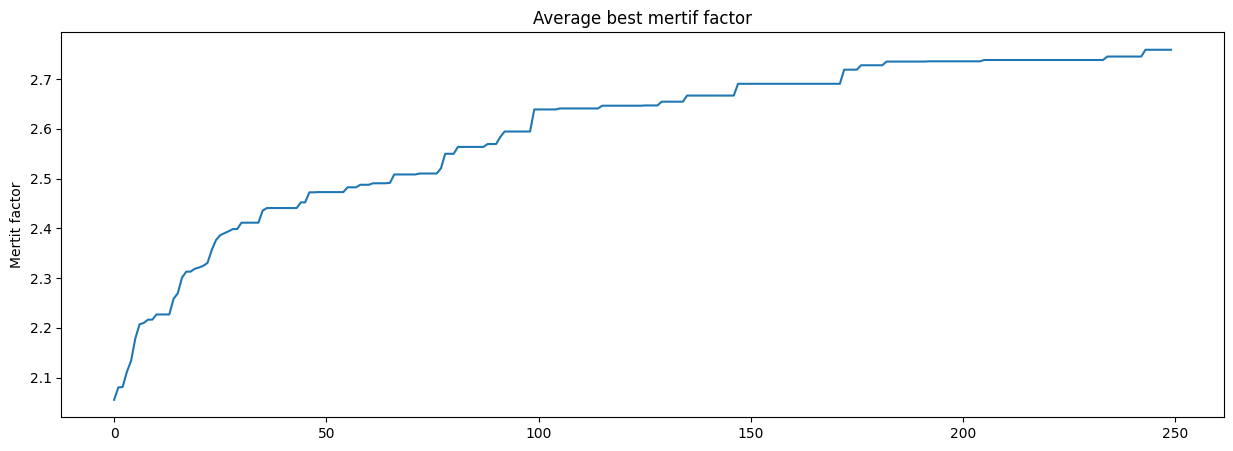

In [466]:
import statistics

plt.figure(figsize=(15,5))
# plt.boxplot([s for s in zip(*data2['best_scores'])])
plt.plot([statistics.mean(s) for s in zip(*data2['best_scores'])])
plt.title('Average best mertif factor')
plt.ylabel('Mertit factor')

plt.show()

In [ ]:
#TODO: run tests for different mutation_prob (suggested:2,5,10,15%) and plot together

In [ ]:
#TODO: implement new mutation mechanism - with mutation_prob/2 when flipping bit at position [i] 
# flip also bit at position [i+2] because they are strongly correlated, then move to i+3
#compare both mutation mechanisms on the plot